# Problem 1

In this problem we are asked to try and predict latitude and longtiude from which music originates based on its features. To begin, we will first build a linear regression regression latitude to the features and longtitude to the features. The MSE and the R^2 for these regressions are stated below.

In [1]:
library(glmnet)
library(lattice)
library(MASS)
library(broom)
library(dplyr)
library(plotmo)
library(MLmetrics)
printf <- function(...) invisible(print(sprintf(...)))
mse <- function(sm) 
    mean(sm$residuals^2)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: plotrix
Loading required package: TeachingDemos

Attaching package: ‘MLmetrics’

The following object is masked from ‘package:base’:

    Recall



In [2]:
# reads in the data set
wdata = read.csv('music_data_less.txt', header = FALSE)
wdata_org = wdata

# Construct the lat and long fitted datasets.
# V69 is the latitude and V70 is the longtitude
fit_lat = lm(V69 ~ . - V70, data=wdata)
fit_lon = lm(V70 ~ . - V69, data=wdata)

[1] "The R^2 value for the fit is: 0.290023"
[1] "The MSE for the fit is: 241.696788"


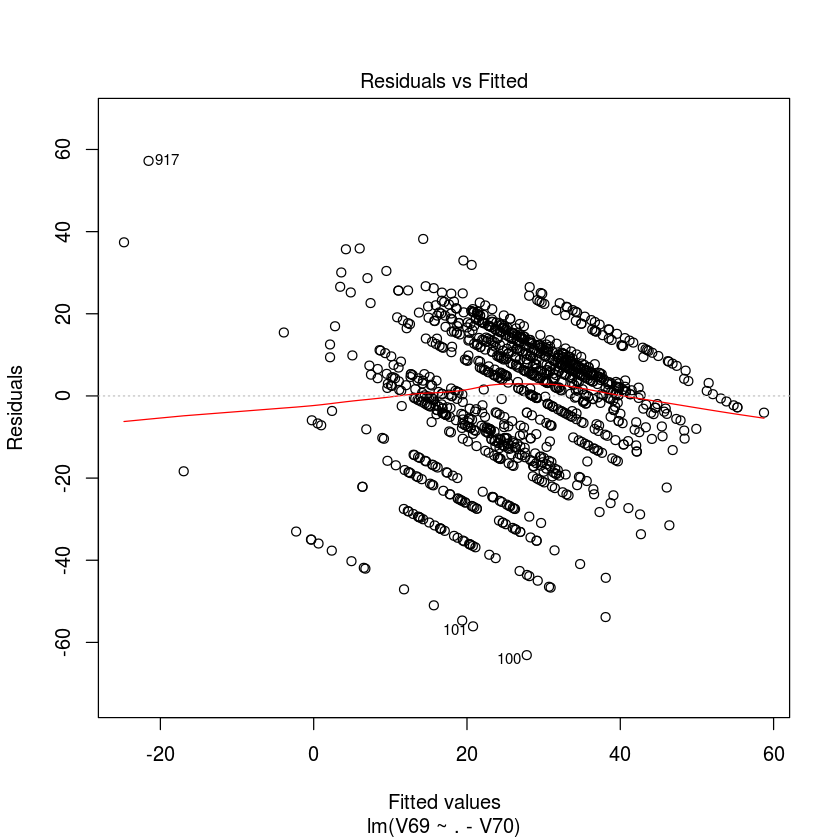

In [3]:
# Plot the residuals vs. the Fitted values for the latitude
plot(fit_lat, which=1)

# Get the value of R^2
printf("The R^2 value for the fit is: %f", summary(fit_lat)$r.squared)
printf("The MSE for the fit is: %f", mse(summary(fit_lat)))

[1] "The R^2 value for the fit is: 0.335537"
[1] "The MSE for the fit is: 1687.573789"


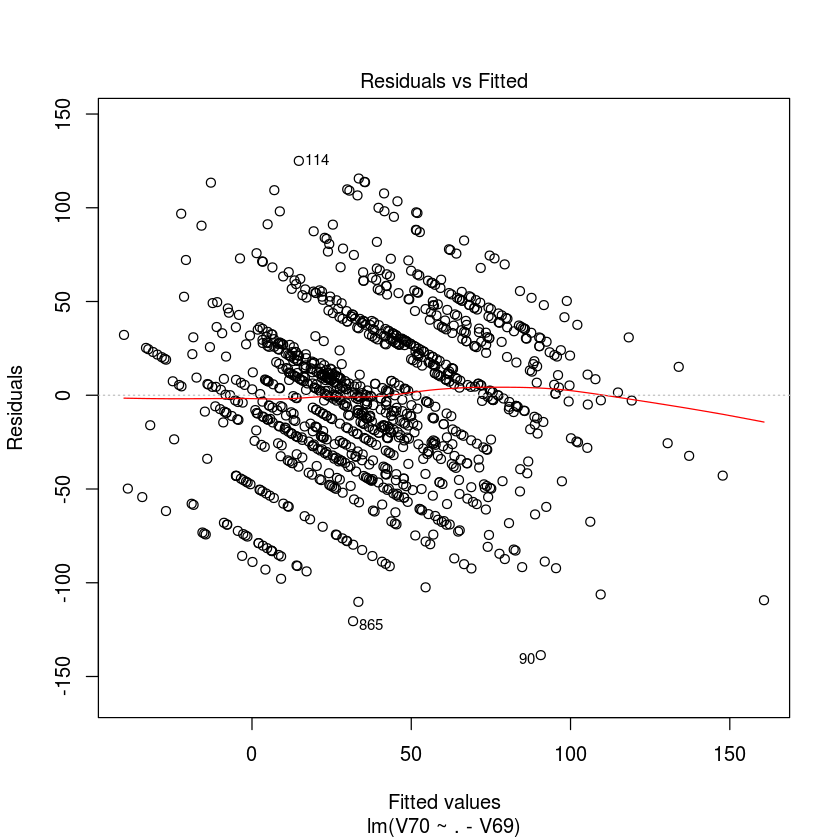

In [4]:
# Plot the residuals vs the fitted values for the longitude
plot(fit_lon, which=1)

# Get the value of R^2
printf("The R^2 value for the fit is: %f", summary(fit_lon)$r.squared)
printf("The MSE for the fit is: %f", mse(summary(fit_lon)))

## Part B
Now that we have seen the performance of the model alone, we now attempt to apply a Box-Cox transformation below. We shift the dependent variables (latitude and longtitude by 360 degrees to set a new origin).

In [5]:
# Now we see the performance of the model when we apply Box-Cox transformations.

# Declare a function that simply adds 360 degrees and apply it to the original dataset.
makePosLat <- function(y) {
    y = y + 360
}

makePosLon <- function(y) {
    y = y + 360
}


wdata = mutate_at(wdata, vars(V69), funs(makePosLat(.)))
wdata = mutate_at(wdata, vars(V70), funs(makePosLon(.)))

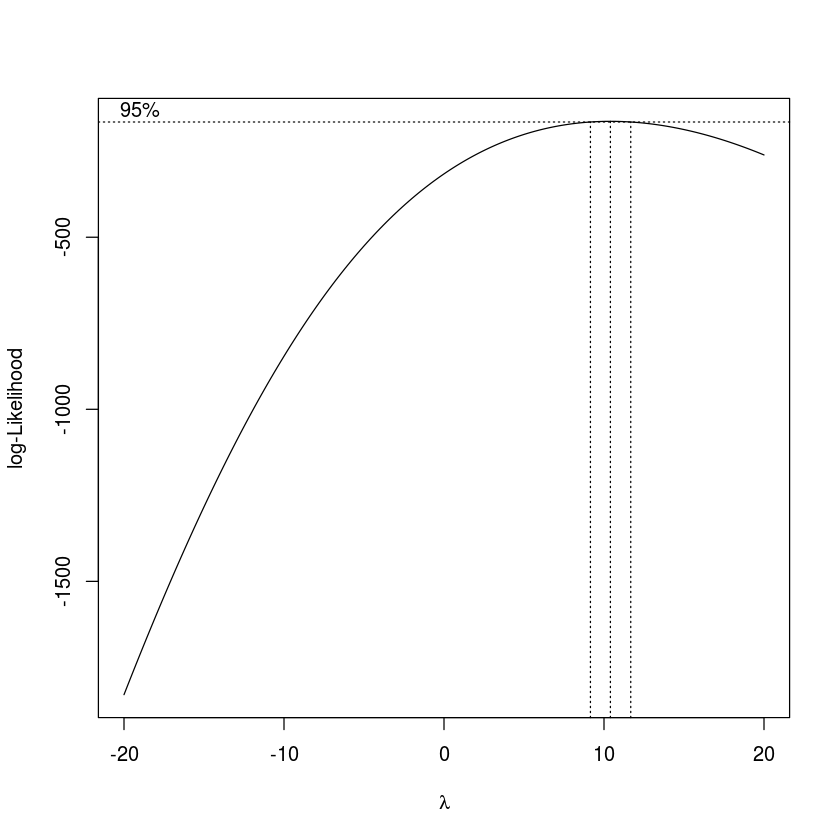

[1] 10.4
[1] 1.151515


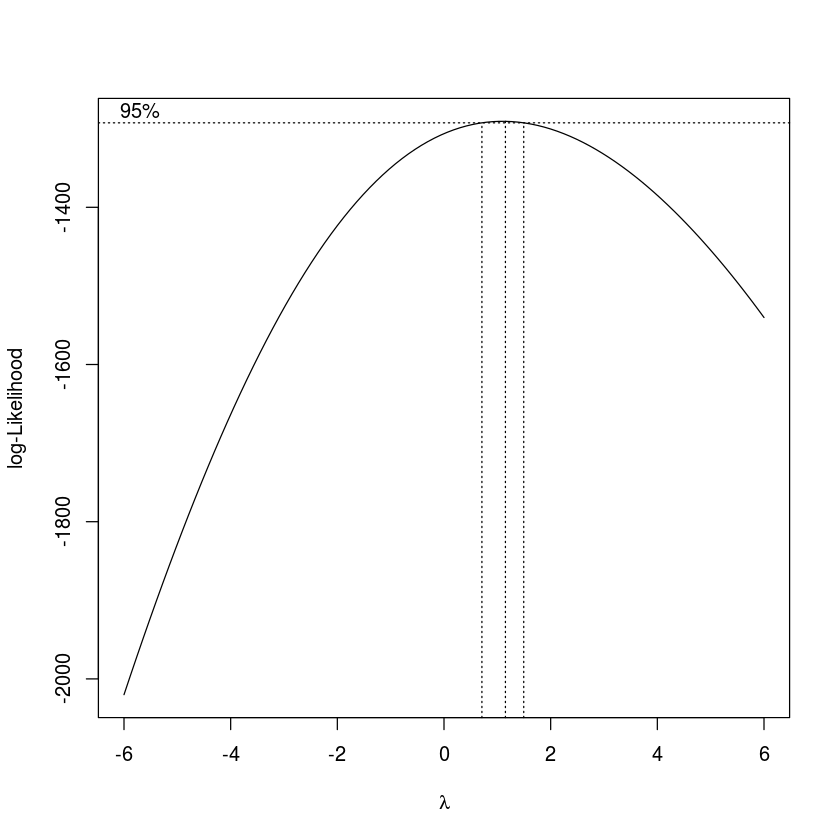

In [6]:
# Apply Box-cox for both latitude and longtitude
lat_box = boxcox(V69 ~ . - V70, data=wdata, lambda = seq(-20, 20, .2))
lon_box = boxcox(V70 ~ . - V69, data=wdata, lambda = seq(-6, 6, .2))

# Reshape the dataframes.
blat = cbind(lat_box$x, lat_box$y)
blon = cbind(lon_box$x, lon_box$y)

# Grab the values for max lambda.
max_lat_lambda = head(blat[order(-lat_box$y)], n=1)
max_lon_lambda = head(blon[order(-lon_box$y)], n=1)

print(max_lat_lambda)
print(max_lon_lambda)

In [7]:
fit_lat_box = lm((((V69^max_lat_lambda) - 1) / max_lat_lambda) ~ . - V70, data=wdata)
fit_lon_box = lm((((V70^max_lon_lambda) - 1) / max_lon_lambda) ~ . - V69, data=wdata)

printf("The R^2 value for the lat fit is: %f", summary(fit_lat_box)$r.squared)
printf("The R^2 value for the lon fit is: %f", summary(fit_lon_box)$r.squared)

[1] "The R^2 value for the lat fit is: 0.322888"
[1] "The R^2 value for the lon fit is: 0.335884"


We see that the performance of the model did not change significantly when applying a Box-Cox transformation. (Using a tolerance that is outlined here https://piazza.com/class/iy1tbcofhoi60u?cid=326). Therefore, for the rest of the excercises we will use the raw dataset to see if there are significant increases in performance when applying L1 and L2 regression. First, we will try to perform a regression regularized by L2. 

## Part C
For the next two problems we will make use of the library glmnet to produce various regularized regression plots and analyze their respective performance.

In [8]:
# Get the relevant splits.
wdata_org = na.omit(wdata_org)
print(dim(wdata_org))
X <- as.matrix(subset(wdata_org, select=-c(V69,V70)))

y_lat <- as.double(as.matrix(wdata_org[, ncol(wdata_org) - 1]))
y_lon <- as.double(as.matrix(wdata_org[, ncol(wdata_org)]))

[1] 1059   70


In [9]:
# Use cross validation to 
cv.ridge_lat <- cv.glmnet(X, y_lat, alpha=0)
cv.ridge_lon <- cv.glmnet(X, y_lon, alpha=0)

#Get the lambda values that produced the minimum error.
#Print the values of the best value of lambda.
printf("The best value of lambda for lat: %f", cv.ridge_lat$lambda.min)
printf("The best value of lambda for lon: %f", cv.ridge_lon$lambda.min)

# Get the R^2 value
p1 <- predict(cv.ridge_lat, X, s="lambda.min")
p2 <- predict(cv.ridge_lon, X, s="lambda.min")

[1] "The best value of lambda for lat: 8.382875"
[1] "The best value of lambda for lon: 3.687688"


In [10]:
# Compute a 'psuedo' R^2 value for each of the regularizations. This will vary during the splits for Cross validation.
printf("The approximate ridge regression latitude R^2 score is: %f", R2_Score(p1, y_lat))
printf("The approximate ridge regression longtitude R^2 score is: %f", R2_Score(p1, y_lon))


[1] "The approximate ridge regression latitude R^2 score is: 0.237168"
[1] "The approximate ridge regression longtitude R^2 score is: -0.044789"


[1] "The value of the MSE for the best value of lambda is: 280.676686"


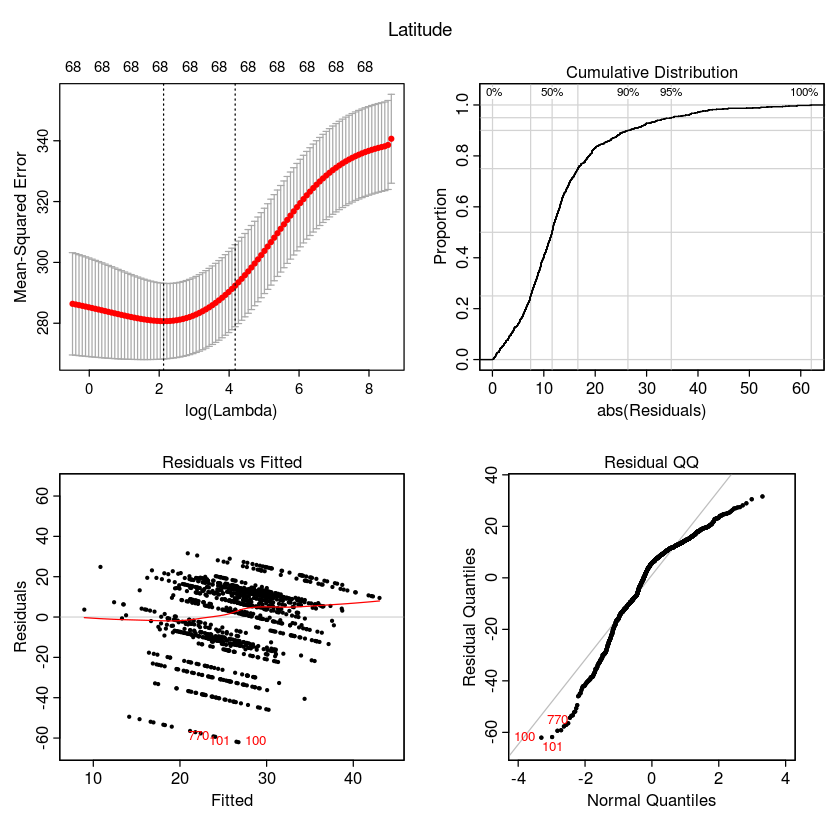

In [11]:
# First see the performance of ridge regularization for predicting latitude.
plotres(cv.ridge_lat, caption='Latitude')

# Compute the MSE for the best value of Lambda.
ridge_lat_mse <- min(cv.ridge_lat$cvm)
printf("The value of the MSE for the best value of lambda is: %f", ridge_lat_mse)

[1] "The value of the MSE for the best value of lambda is: 1943.170139"


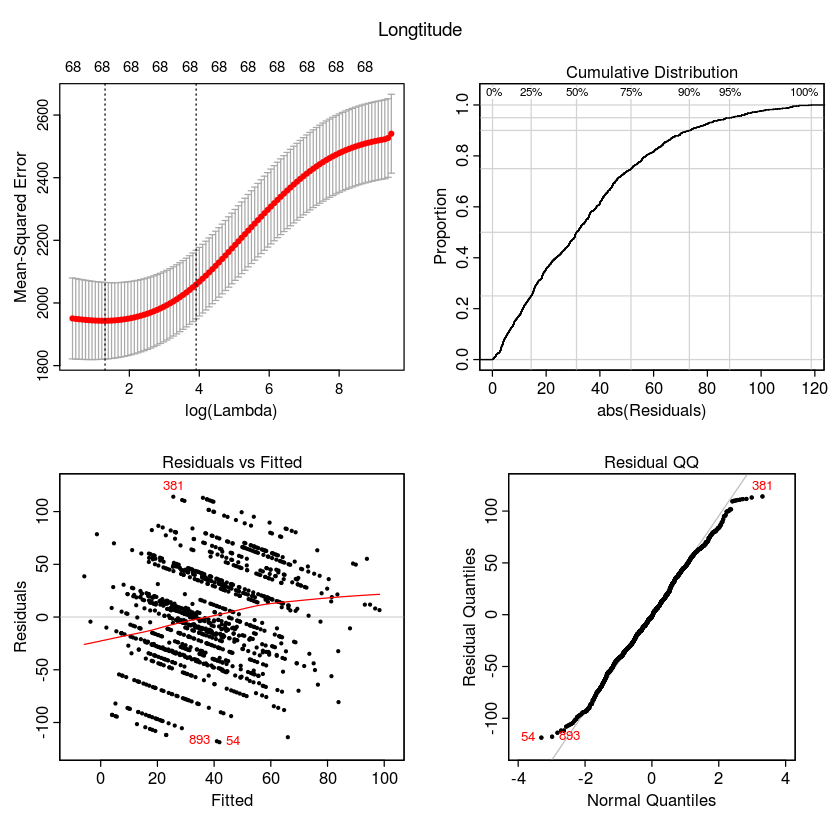

In [12]:
# First see the performance of ridge regularization for predicting longitude
plotres(cv.ridge_lon, caption='Longtitude')

# Compute the MSE for the best value of Lambda.
ridge_lon_mse <- min(cv.ridge_lon$cvm)
printf("The value of the MSE for the best value of lambda is: %f", ridge_lon_mse)

## Analysis
When performing a regression regularized by L2 (ridge regression), it was found that for latitude the best lambda value was approximately 5.777990 and for longtitude it was 4.047233. (These values can change depending on the splits during cross validation). When looking at R^2 values and MSE, it seems that the ridge regression did not improve the performance of the regression.

Now, we perform the same analysis but instead look at a regularization regularized by Lasso Regression.

In [13]:
cv.lasso_lat <- cv.glmnet(X, y_lat, alpha=1)
cv.lasso_lon <- cv.glmnet(X, y_lon, alpha=1)

printf("The best value of lambda for lat: %f", cv.lasso_lat$lambda.min)
printf("The best value of lambda for lon: %f", cv.lasso_lon$lambda.min)

# Get the R^2 value
p3 <- predict(cv.lasso_lat, X, s="lambda.min")
p4 <- predict(cv.lasso_lon, X, s="lambda.min")

[1] "The best value of lambda for lat: 0.502540"
[1] "The best value of lambda for lon: 0.352008"


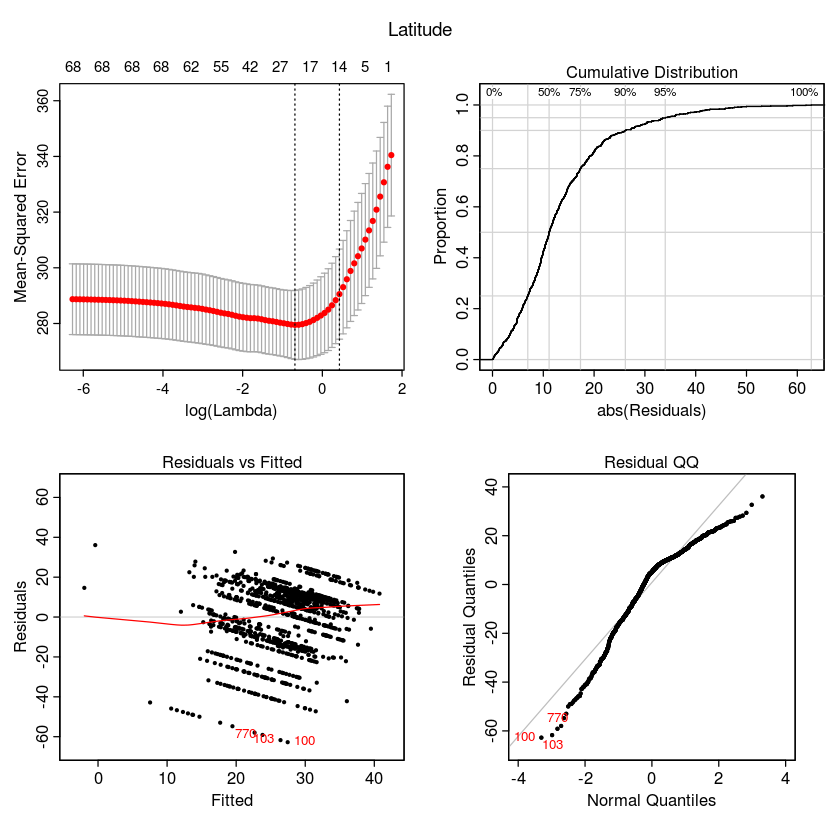

[1] "The value of the MSE for the best value of lambda for latitude is: 279.493073"
[1] "The value of the MSE for the best value of lambda for longitude is: 1942.403365"


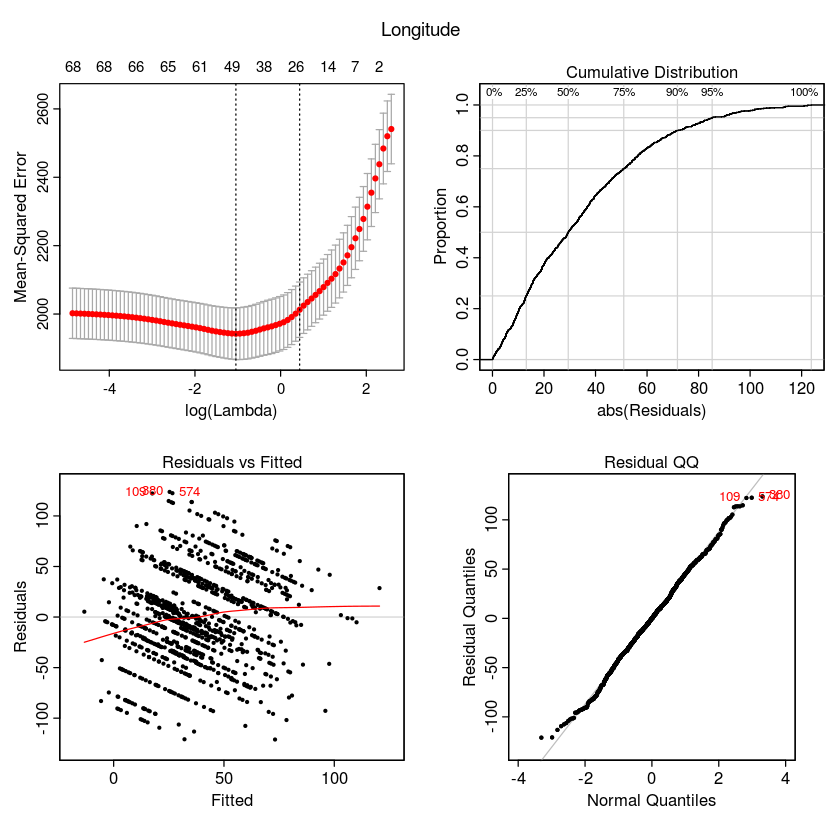

In [14]:
plotres(cv.lasso_lat, caption='Latitude')
plotres(cv.lasso_lon, caption='Longitude')
lasso_lat_mse <- min(cv.lasso_lat$cvm)
lasso_lon_mse <- min(cv.lasso_lon$cvm)
printf("The value of the MSE for the best value of lambda for latitude is: %f", lasso_lat_mse)
printf("The value of the MSE for the best value of lambda for longitude is: %f", lasso_lon_mse)

In [15]:
# Compute a 'psuedo' value for R^2
R2_Score(p3, y_lat)
R2_Score(p4, y_lon)

[1] 0.2268487

[1] 0.32164

Now grab the number of coefficents used by the models.


In [16]:
printf("The number of coefficents used by cv.lasso_lat is: %d", colSums(coef(cv.lasso_lat) != 0))
printf("The number of coefficents used by cv.lasso_lon is: %d", colSums(coef(cv.lasso_lon) != 0))

[1] "The number of coefficents used by cv.lasso_lat is: 15"
[1] "The number of coefficents used by cv.lasso_lon is: 26"


## Analysis for Part C part 2 
The best value for lambda for latitude is approximately 0.457896 and for longtitude 0.352008 at the time of this writing. At the time of this writing, the number of coefficents used to predict latitude is 11 and to predict longitude is 25. The values for R^2 and MSE imply that there isn't a significant improvment when doing L2 regularization for both Latitude and Longtitude.